In [ ]:
import numpy as np # линейная алгебра
import pandas as pd # обработка данных, CSV-файл ввода-вывода (например, pd.read_csv)
from matplotlib import pyplot as plt #Построение графиков
from glob import glob #повторное создание массива файлов в каталогах
from keras.models import Sequential #для нейросетевых моделей
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator #Увеличение объема данных и их предварительная обработка
from keras.utils import to_categorical #Для прямого кодирования
from keras.optimizers import Adam, Nadam, SGD, RMSprop, Adadelta #Для оптимизации нейронной сети
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import load_model

In [ ]:
#Подключаю гугл диск к google Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Смотрю какие папки есть на диске
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/dataset

 ARXIV_V5_CHESTXRAY.pdf   README_CHESTXRAY.pdf	  test
 BBox_List_2017.csv	  sample_labels.csv	  test_list.txt
 Data_Entry_2017.csv	 'saved model 2.0'	  train
 FAQ_CHESTXRAY.pdf	 'saved model Adadelta'   train_val_list.txt
 LOG_CHESTXRAY.pdf	 'saved model Adam'	  val


In [ ]:
#Присваивание путей в соответствующие переменные 
path_train = "/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/train"
path_val = "/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/val"
path_test = "/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/test"

In [ ]:
#Data preprocessing and analysis
classes = ["MALE", "FEMALE"]
train_data = glob(path_train+"/MALE/*.png")
train_data += glob(path_train+"/FEMALE/*.png")
data_gen = ImageDataGenerator() #Augmentation happens here
#But in this example we're not going to give the ImageDataGenerator method any parameters to augment our data.

In [ ]:
#Принимаем на вход каталог и генерируем пакеты данных. размер изображений 226*226. Присваивает категорию classes, созданную ранее
train_batches = data_gen.flow_from_directory(path_train, target_size = (226, 226), classes = classes, class_mode = "categorical")
val_batches = data_gen.flow_from_directory(path_val, target_size = (226, 226), classes = classes, class_mode = "categorical")
test_batches = data_gen.flow_from_directory(path_test, target_size = (226, 226), classes = classes, class_mode = "categorical")

Found 25805 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_batches.image_shape

(226, 226, 3)

In [ ]:
#Это сверточная искусственная нейронная сеть
#Модель VGG16
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=train_batches.image_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 226, 226, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 226, 226, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 115, 115, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     7

In [ ]:
def schedule(epoch, lr):
    if lr < 10**(-12):
      return 0.001
    return lr*(0.7)
callbacks = [ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/(повышение до 0.001)CNN_lr=0.1-conv.hdf5', monitor='val_accuracy', save_best_only=True)]
callbacks += [CSVLogger(filename="/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/run_log_(0.1-0.001).csv", separator=",", append=True)]
#callbacks +=[ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.00001,cooldown=0, min_lr=0)]
callbacks += [LearningRateScheduler(schedule, verbose=1)]

In [ ]:
optimizer = Adadelta(learning_rate=0.1, rho=0.95, epsilon=1e-07, name='Adadelta')
#optimizer = Adam(learning_rate= 0.0001)#Оптимизатор типа Adam, самый популярный и эффективный, скорость обучения=0.0001
#early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_accuracy", mode="max", verbose = 2)#Остановка обучения, когда модель перестала увеличивать точность
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)#Настраивает процесс обучения модели
history = model.fit_generator(epochs=5,  shuffle=True, callbacks=callbacks, validation_data=val_batches, generator=train_batches, steps_per_epoch=201,validation_steps=7, verbose=1)# Поставляет модель Keras Sequential на основе данных, сгенерированных пакетно

In [ ]:
history = model.fit_generator(epochs=20,  shuffle=True, callbacks=callbacks, validation_data=val_batches, generator=train_batches, steps_per_epoch=201,validation_steps=7, verbose=1)# Поставляет модель Keras Sequential на основе данных, сгенерированных пакетно

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 1.220703143189894e-05.
Epoch 1/5
201/201 [==============================] - 2666s 13s/step - loss: 0.2461 - accuracy: 0.8937 - val_loss: 0.2948 - val_accuracy: 0.8616

Epoch 00002: LearningRateScheduler reducing learning rate to 6.10351571594947e-06.
Epoch 2/5
201/201 [==============================] - 2024s 10s/step - loss: 0.2458 - accuracy: 0.8951 - val_loss: 0.2736 - val_accuracy: 0.8884

Epoch 00003: LearningRateScheduler reducing learning rate to 3.051757857974735e-06.
Epoch 3/5
201/201 [==============================] - 1543s 8s/step - loss: 0.2490 - accuracy: 0.8926 - val_loss: 0.2447 - val_accuracy: 0.8929

Epoch 00004: LearningRateScheduler reducing learning rate to 1.5258789289873675e-06.
Epoch 4/5
201/201 [==============================] - 1343s 7s/step - loss: 0.2485 - accuracy: 0.8941 - val_loss: 0.3266 - val_accuracy: 0.8527

Epoch 000

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/CNN_lr=0.1_conv.h5')

In [ ]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/(повышение до 0.001)CNN_lr=0.1-conv.hdf5')

In [ ]:
scores = model.evaluate_generator(test_batches)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 83.50%


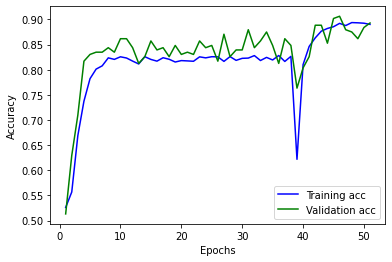

In [ ]:
history_dict=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Networks/Пол/dataset/run_log_(0.1).csv")
acc_values = history_dict["accuracy"].tolist()
val_acc_values = history_dict["val_accuracy"].tolist()
epochs = history_dict["epoch"].tolist()
#acc_values = acc_values[:22]
#val_acc_values = val_acc_values[:22]
#epochs = epochs[:22]
for i in range(len(epochs)):
  epochs[i] = i+1
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

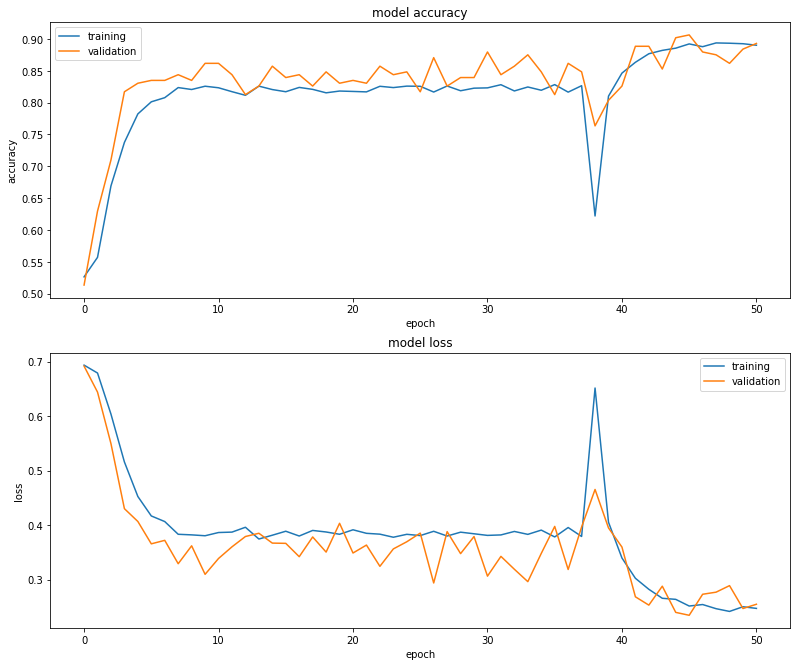

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(11,9))
plt.tight_layout()
acc_values = history_dict["accuracy"].tolist()
val_acc_values = history_dict["val_accuracy"].tolist()
loss_values = history_dict["loss"].tolist()
val_loss_values = history_dict["val_loss"].tolist()
#acc_values = acc_values[1:]
#val_acc_values = val_acc_values[1:]
#loss_values = loss_values[1:]
#val_loss_values = val_loss_values[1:]
display_training_curves(acc_values, val_acc_values, 'accuracy', 211)
display_training_curves(loss_values, val_loss_values, 'loss', 212)